In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, RepeatVector, TimeDistributed, ConvLSTM2D, BatchNormalization, Flatten
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve, auc

# Load the data (replace with your dataset file if applicable)
data = pd.read_csv('https://drive.google.com/uc?id=18Hz8VSLDWvM0GwNuXyBUKoGNPhYKVzFF')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Prepare data
sequence_length = 48
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length]  # Next point is the label
        sequences.append((seq, label))
    return np.array(sequences)

true_anomalies_dates = [
    '2014-11-02', '2014-11-27', '2014-12-25',
    '2015-01-01',
    '2015-01-26', '2015-01-27'
]

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Add true anomaly labels to the DataFrame
data['is_anomaly'] = data.index.isin(pd.to_datetime(true_anomalies_dates)).astype(int)
true_labels = data.index.isin(pd.to_datetime(true_anomalies_dates)).astype(int)
true_labels = true_labels[sequence_length:]

def plot_roc(true_labels, scores, label):
    fpr, tpr, _ = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random chance line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for {label}')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    return roc_auc

C:\Users\aqils\AppData\Local\Temp\ipykernel_29796\4256084930.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 64)            18432     
                                                                 
 dropout (Dropout)           (None, 48, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 7)                 231       
                                                                 
Total params: 31,079
Trainable params: 31,079
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
257/257 [==============================] 

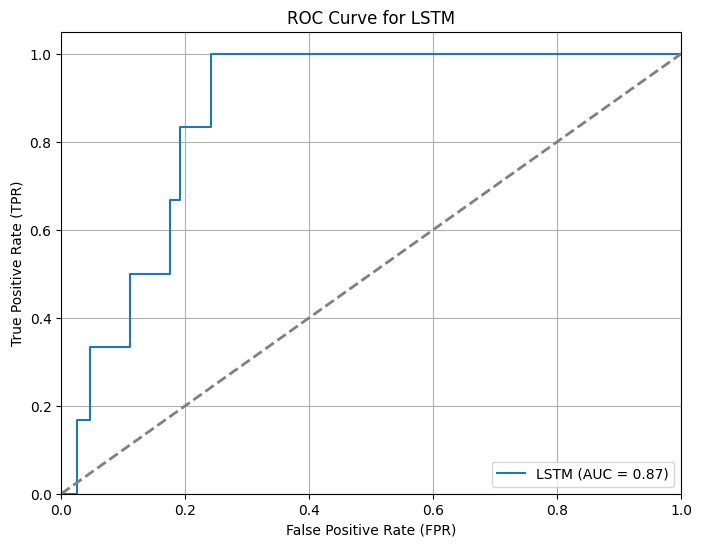

0.8679135008766803

In [ ]:
# Create sequences for input
sequences1 = create_sequences(scaled_data, sequence_length)
X1, y1 = zip(*sequences1)
X1, y1 = np.array(X1), np.array(y1)

# --- LSTM Model ---
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X1.shape[1], X1.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(X1.shape[2])
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

history_lstm = model_lstm.fit(X1, y1, epochs=10, batch_size=32, validation_split=0.2)
predictions_lstm = model_lstm.predict(X1)
X1_last = X1[:, -1, :]
reconstruction_error_lstm = np.mean(np.abs(predictions_lstm - X1_last), axis=1)

plot_roc(true_labels, reconstruction_error_lstm, 'LSTM')

C:\Users\aqils\AppData\Local\Temp\ipykernel_29796\4256084930.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 7)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 48, 64)            18432     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVector  (None, 48, 32)           0         
 )                                                               
                                                                 
 lstm_4 (LSTM)               (None, 48, 32)            8320      
                                                                 
 lstm_5 (LSTM)               (None, 48, 64)            24832     
                                                             

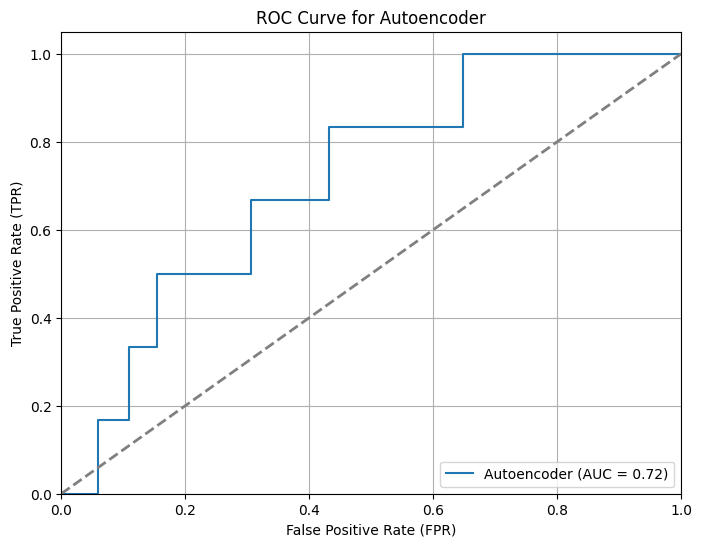

0.7151438405091239

In [3]:
# --- Autoencoder Model ---
sequences2 = create_sequences(scaled_data, sequence_length)
X2 = np.array([seq[0] for seq in sequences2])

timesteps = X2.shape[1]
features = X2.shape[2]

input_layer = Input(shape=(timesteps, features))
encoded = LSTM(64, activation="relu", return_sequences=True)(input_layer)
encoded = LSTM(32, activation="relu", return_sequences=False)(encoded)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(32, activation="relu", return_sequences=True)(decoded)
decoded = LSTM(64, activation="relu", return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(features, activation="sigmoid"))(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

history_ae = autoencoder.fit(X2, X2, epochs=10, batch_size=32, validation_split=0.2)
reconstructed_ae = autoencoder.predict(X2)
reconstruction_error_ae = np.mean(np.abs(reconstructed_ae - X2), axis=(1, 2))

plot_roc(true_labels, reconstruction_error_ae, 'Autoencoder')

C:\Users\aqils\AppData\Local\Temp\ipykernel_29796\4256084930.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 48, 1, 6, 64)      33536     
                                                                 
 batch_normalization (BatchN  (None, 48, 1, 6, 64)     256       
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 5, 32)          24704     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               20608     
                                                                 
 dense_3 (Dense)             (None, 336)               43344     
                                                      

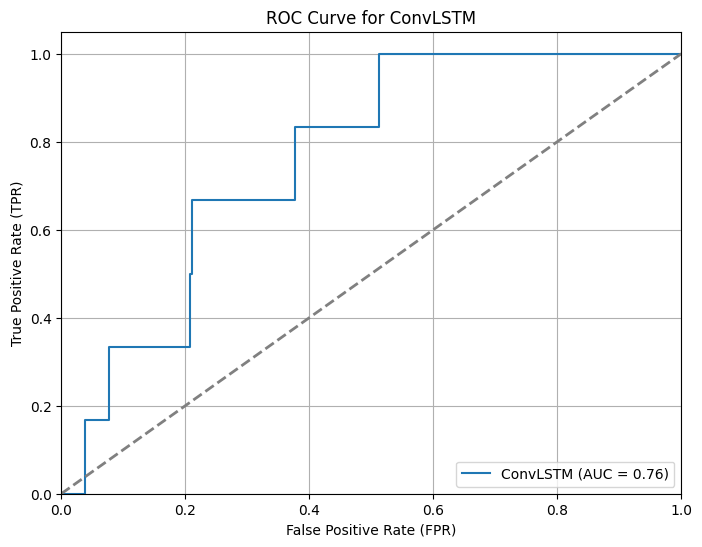

0.7626144554841223

In [4]:
# --- ConvLSTM Model ---
sequences3 = create_sequences(scaled_data, sequence_length)
X3 = np.array([seq[0] for seq in sequences3])
X3 = X3.reshape((X3.shape[0], X3.shape[1], 1, X3.shape[2], 1))

model_convlstm = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1, 2), activation='relu', input_shape=(X3.shape[1], 1, X3.shape[3], 1), return_sequences=True),
    BatchNormalization(),
    ConvLSTM2D(filters=32, kernel_size=(1, 2), activation='relu', return_sequences=False),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(X3.shape[1] * X3.shape[3], activation='sigmoid')
])

model_convlstm.compile(optimizer='adam', loss='mse')
model_convlstm.summary()

X3_flattened = X3.reshape(X3.shape[0], -1)
history_convlstm = model_convlstm.fit(X3, X3_flattened, epochs=10, batch_size=32, validation_split=0.2)
reconstructed_convlstm = model_convlstm.predict(X3).reshape(X3.shape[0], -1)
reconstruction_error_convlstm = np.mean(np.abs(reconstructed_convlstm - X3_flattened), axis=1)

plot_roc(true_labels, reconstruction_error_convlstm, 'ConvLSTM')

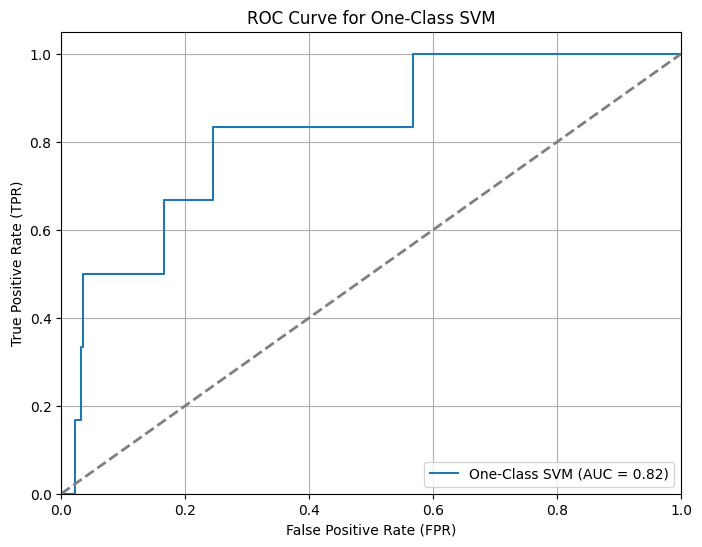

0.8223611919074397

In [31]:
# --- One-Class SVM Model ---
svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.9)
svm.fit(scaled_data)
scores_svm = -svm.decision_function(scaled_data)
true_labels4 = data['is_anomaly'].values

plot_roc(true_labels4, scores_svm, 'One-Class SVM')

C:\Users\aqils\AppData\Local\Temp\ipykernel_29796\4256084930.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences)


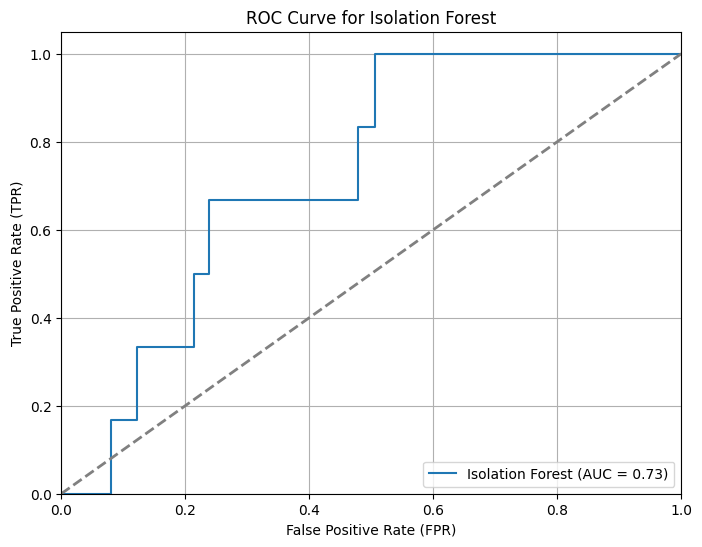

0.7267355023053444

In [35]:
# --- Isolation Forest Model ---
sequences5 = create_sequences(scaled_data, sequence_length)
X5 = np.array([seq[0] for seq in sequences5])
X5_flattened = X5.reshape(X5.shape[0], -1)

iso_forest = IsolationForest(n_estimators=300, contamination=0.1, random_state=100)
iso_forest.fit(X5_flattened)
scores_iso_forest = -iso_forest.decision_function(X5_flattened)

plot_roc(true_labels, scores_iso_forest, 'Isolation Forest')

In [34]:
# from statsmodels.tsa.seasonal import STL

# # data = pd.read_csv('https://drive.google.com/uc?id=18Hz8VSLDWvM0GwNuXyBUKoGNPhYKVzFF') 
# # data['timestamp'] = pd.to_datetime(data['timestamp'])
# # data.set_index('timestamp', inplace=True)

# # Select one column for STL decomposition (e.g., value)
# column_to_decompose = 'value'
# # Ensure the timestamp index has a uniform frequency
# data = data.asfreq('30T')  # Set frequency to 30 minutes (adjust as needed)

# # Re-select the column for decomposition after setting frequency
# data_to_decompose = data[column_to_decompose]

# # Apply STL decomposition
# stl = STL(data_to_decompose, seasonal=13)
# result = stl.fit()

# # Residual anomaly detection
# residuals = result.resid
# threshold = 3 * np.std(residuals)  # Define anomaly threshold
# anomalies = np.abs(residuals) > threshold

# # Add anomaly flag to the dataset
# data['is_anomaly'] = anomalies.astype(int)

# # Generate true anomaly labels (1 for anomaly, 0 for normal)
# data['true_anomaly'] = data.index.isin(pd.to_datetime(true_anomalies_dates)).astype(int)

# # Compute ROC curve and AUC
# fpr, tpr, thresholds = roc_curve(data['true_anomaly'], data['is_anomaly'])
# roc_auc = auc(fpr, tpr)

# # Plot the ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random chance line
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR)')
# plt.title('ROC Curve for STL+Residual Anomaly Detection')
# plt.legend(loc="lower right")
# plt.grid()
# plt.show()